# Track videos with your trained network

Once you have a well-trained network, you can use it to extract the position of the different objects in a video.


## GPU access

You will need to get a Runtime with GPU access. Click on Runtime/Change runtime type. Select GPU as hardware accelerator.

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 941 (delta 194), reused 309 (delta 188), pack-reused 621
Receiving objects: 100% (941/941), 123.86 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (584/584), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.0

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=16048 sha256=584d6e2d291534cde6b00ad1014e5a7713b850680846fb363d3081e84976e24c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xazijlbn/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/dsfolder"
if os.path.exists(fn):
  print("We can access the dsfolder directory.")
else:
  raise IOError("Problem accessing the dsfolder directory.")

Mounted at /content/drive
We can access the dsfolder directory.


In [2]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/dsfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/dsfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40666553378105164, 0.45300230383872986, 0.5148566961288452], 'stds': [0.23905879259109497, 0.2506697177886963, 0.2679229974746704]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [3]:
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.utils import extract_object_position_from_video

In [4]:
dataset = UNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinate_dir=project.coordinate_dir)

In [5]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


In [6]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)
project.load_model(model)
_ = model.eval()

In [7]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))

Loading valTransform from /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/augmentation/valTransform


In [8]:
valTransform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40666553378105164, 0.45300230383872986, 0.5148566961288452], std=[0.23905879259109497, 0.2506697177886963, 0.2679229974746704], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

The transformation should only include the normalization. No translation, flip or cropping.

In [9]:
video_fn = '/content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.mp4'
if os.path.exists(video_fn):
  print("We can access the video file.")
else:
  raise IOError("Problem accessing {}".format(video_fn))

We can access the video file.


In [10]:
df = extract_object_position_from_video(project=project,transform=valTransform,
                                        model=model,device=device,
                                        video_fn=video_fn,blobMinArea=10,
                                        plotData=False,
                                        #nFrames=10000,
                                        #startFrameIndex=15*60*3,
                                        BGR2RGBTransformation=False)

Number of frames in /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.mp4: 5795
Processing 5795 frames from index 0


  0%|          | 0/5795 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5795/5795 [05:29<00:00, 17.60it/s]


In [16]:
tracking_fn = (os.path.splitext(video_fn)[0]) + ".csv"
print("Saving ",tracking_fn)
df.to_csv(tracking_fn,index=False)

Saving  /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.csv


In [17]:
df = pd.read_csv(tracking_fn)
df

,f1_x,f1_y,f1_p,f2_x,f2_y,f2_p,f3_x,f3_y,f3_p,f4_x,f4_y,f4_p
0,NaN,NaN,0.000227,NaN,NaN,0.189434,202.462021,5.300810,0.350482,NaN,NaN,0.000334
1,NaN,NaN,0.000227,NaN,NaN,0.190291,202.462021,5.300810,0.350441,NaN,NaN,0.000334
2,NaN,NaN,0.000227,NaN,NaN,0.190447,202.449005,5.335791,0.348212,NaN,NaN,0.000334
3,NaN,NaN,0.000548,166.941193,27.614511,0.570472,NaN,NaN,0.221817,NaN,NaN,0.000216
4,NaN,NaN,0.000546,166.941193,27.614511,0.570519,NaN,NaN,0.222833,NaN,NaN,0.000216
...,...,...,...,...,...,...,...,...,...,...,...,...
5790,332.023895,133.499542,0.965338,285.384460,119.966080,0.995167,258.859894,120.152641,0.998346,228.507675,134.472931,0.988664
5791,332.235138,133.782211,0.962719,285.686157,120.102440,0.994521,259.101837,120.321022,0.997936,228.952621,134.450775,0.987609
5792,332.235138,133.782211,0.962754,285.677765,120.082977,0.994404,259.102509,120.319450,0.997932,228.968323,134.429306,0.987536
5793,332.235138,133.782211,0.962736,285.675323,120.088974,0.994510,259.127441,120.457489,0.998175,228.936188,134.470093,0.987929


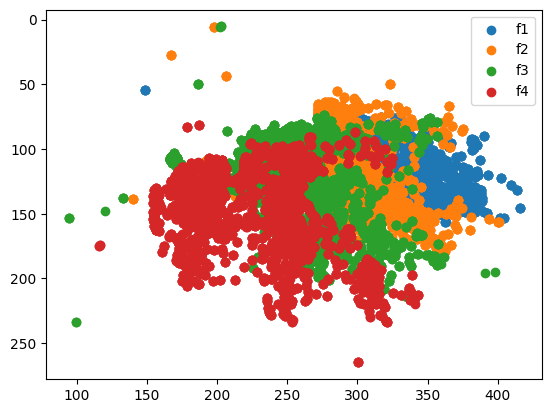

In [18]:
for obj in project.object_list:
    plt.scatter(df[f"{obj}_x"],df[f"{obj}_y"],label=obj)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.legend()


In [19]:
obj = project.object_list[0]
cName = f"{obj}_x"
print("Number of Nan:", np.sum(np.isnan(df[cName])))
print("percentage of Nan: {:.2f}%".format(np.sum(np.isnan(df[cName]))/len(df[cName])*100))

Number of Nan: 482
percentage of Nan: 8.32%


We can then create a video with the labels.

In [20]:
label_fn = (os.path.splitext(video_fn)[0]) + "_label.avi"
print(video_fn, tracking_fn,label_fn)


/content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.mp4 /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.csv /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand_label.avi


In [22]:
from unetTracker.utils import label_video

In [24]:
label_video(project,video_fn,tracking_fn,label_fn)

Number of frames: 5795


100%|██████████| 5795/5795 [00:17<00:00, 327.02it/s]
